# Discovering hidden factors of variation in deep networks

**This is an example of how to implement the autoencoder architecture from [Cheung et al. (2014)](http://arxiv.org/abs/1412.6583) in Lasagne.**

Some setup code follows, as well as code to load the MNIST dataset.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import theano
import theano.tensor as T
import lasagne as nn

Using gpu device 0: GeForce GTX 980


The dataset (15MB) can be downloaded with:

In [3]:
!wget -N http://deeplearning.net/data/mnist/mnist.pkl.gz

--2015-08-22 17:45:09--  http://deeplearning.net/data/mnist/mnist.pkl.gz
Resolving deeplearning.net (deeplearning.net)... 132.204.26.28
Connecting to deeplearning.net (deeplearning.net)|132.204.26.28|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16168813 (15M) [application/x-gzip]
Server file no newer than local file ‘mnist.pkl.gz’ -- not retrieving.



In [4]:
import gzip
import cPickle as pickle
import sys

PY2 = sys.version_info[0] == 2 # check if we're running Python 2 or 3
# we need to know this because unpickling is slightly different in both cases

if PY2:
    def pickle_load(f, encoding):
        return pickle.load(f)
else:
    def pickle_load(f, encoding):
        return pickle.load(f, encoding=encoding)

def load_data():
    """Get data with labels, split into training, validation and test set."""
    with gzip.open('mnist.pkl.gz', 'rb') as f:
        data = pickle_load(f, encoding='latin-1')
    X_train, y_train = data[0]
    X_valid, y_valid = data[1]
    X_test, y_test = data[2]

    return dict(
        X_train=theano.shared(nn.utils.floatX(X_train)),
        y_train=T.cast(theano.shared(y_train), 'int32'),
        X_valid=theano.shared(nn.utils.floatX(X_valid)),
        y_valid=T.cast(theano.shared(y_valid), 'int32'),
        X_test=theano.shared(nn.utils.floatX(X_test)),
        y_test=T.cast(theano.shared(y_test), 'int32'),
        num_examples_train=X_train.shape[0],
        num_examples_valid=X_valid.shape[0],
        num_examples_test=X_test.shape[0],
        input_dim=X_train.shape[1],
        output_dim=10,
    )

**We'll define the model listed in the first column of Table 1 in the paper.**

This model has an encoder with two ReLU layers. In the paper they both have 500 units but we'll make this configurable so we can speed up the experiment a bit if necessary.

On top of the encoder are two representation layers: one is a 10-way softmax layer which represents the class of the input. This is the observed representation layer. Then there is also a latent representation layer which has two additional linear units (the authors use only two units for easy visualization).

Both representation layers are concatenated and the decoder is stacked on top. This consists of three layers: two hidden ReLU layers with again 500 units, and finally a linear reconstruction layer with 784 outputs.

In [5]:
def build_model(input_dim, output_dim, batch_size,
                num_hidden_units=500):
    l_in = nn.layers.InputLayer((batch_size, input_dim))
    
    # encoder
    l_encoder1 = nn.layers.DenseLayer(l_in, num_units=num_hidden_units)
    l_encoder2 = nn.layers.DenseLayer(l_encoder1, num_units=num_hidden_units)
    
    # learned representation
    l_observed = nn.layers.DenseLayer(l_encoder2, num_units=output_dim,
                                      nonlinearity=T.nnet.softmax)
    
    l_latent = nn.layers.DenseLayer(l_encoder2, num_units=2,
                                    nonlinearity=None) # linear
    
    l_representation = nn.layers.concat([l_observed, l_latent])
    
    # decoder
    l_decoder1 = nn.layers.DenseLayer(l_representation, num_units=num_hidden_units)
    l_decoder2 = nn.layers.DenseLayer(l_decoder1, num_units=num_hidden_units)
    l_decoder_out = nn.layers.DenseLayer(l_decoder2, num_units=input_dim,
                                       nonlinearity=None)
    
    return l_in, l_decoder_out, l_observed, l_latent

Next, **we'll define the cost function**. This consists of three parts: `alpha * U + beta * S + gamma * C` (formula 3 in the paper). `U` is the reconstruction cost, `S` is the supervised cost and `C` is the so-called "XCov" cost which disentangles the observed and latent variables of the encoder.

In [6]:
def cost(x, y, x_recon, y_pred, z, alpha=1.0, beta=10.0, gamma=10.0):
    """
    x, y: the input and the corresponding label
    x_recon: the model reconstruction of the input
    y_pred: the model prediction (observed variables)
    z: the latent variables
    """
    # reconstruction cost: mean squared error
    U = T.mean((x - x_recon)**2)
    
    # supervised cost: categorical cross-entropy
    S = T.mean(T.nnet.categorical_crossentropy(y_pred, y))
    
    # XCov cost: cross-covariance
    y_pred_mean = T.mean(y_pred, axis=0, keepdims=True)
    z_mean = T.mean(z, axis=0, keepdims=True)
    y_pred_centered = y_pred - y_pred_mean # (n, i)
    z_centered = z - z_mean # (n, j)
    
    outer_prod = (y_pred_centered.dimshuffle(0, 1, 'x') *
                  z_centered.dimshuffle(0, 'x', 1)) # (n, i, j)
    C = 0.5 * T.sum(T.sqr(T.mean(outer_prod, axis=0)))
    
    # the total cost is a weighted sum
    return alpha * U + beta * S + gamma * C

Now let's tie everything together: **load up the data, build the model, compile Theano functions.**

In [7]:
num_epochs = 200
batch_size = 100

print("Loading data...")
dataset = load_data()

print("Building model and compiling functions...")
l_in, l_decoder_out, l_observed, l_latent = build_model(
    input_dim=dataset['input_dim'],
    output_dim=dataset['output_dim'],
    batch_size=batch_size,
)

x = l_in.input_var
y = T.ivector('y')
x_recon, y_pred, z = nn.layers.get_output([l_decoder_out, l_observed, l_latent])
# Note that we call get_output() once to get all the model outputs.
# This is to guarantee they are consistent and share computations where
# possible. When the network contains nondeterminism (such as dropout
# regularization), guaranteeing this consistency is crucially important.
loss = cost(x, y, x_recon, y_pred, z)
params = nn.layers.get_all_params(l_decoder_out)

# # add some L2 regularization
# params_reg = nn.layers.get_all_params(l_decoder_out, regularizable=True)
# reg = sum(T.sum(p**2) for p in params_reg)
# loss += 0.01 * reg

# The authors mention that they use adadelta, let's do the same
updates = nn.updates.adadelta(loss, params)

# compile iteration functions
batch_index = T.iscalar('batch_index')
batch_slice = slice(batch_index * batch_size,
                    (batch_index + 1) * batch_size)

pred = T.argmax(y_pred, axis=1)
accuracy = T.mean(T.eq(pred, y), dtype=theano.config.floatX)

iter_train = theano.function(
    [batch_index], loss,
    updates=updates,
    givens={
        x: dataset['X_train'][batch_slice],
        y: dataset['y_train'][batch_slice],
    },
)

iter_valid = theano.function(
    [batch_index], [loss, accuracy],
    givens={
        x: dataset['X_valid'][batch_slice],
        y: dataset['y_valid'][batch_slice],
    },
)

iter_test = theano.function(
    [batch_index], [loss, accuracy],
    givens={
        x: dataset['X_test'][batch_slice],
        y: dataset['y_test'][batch_slice],
    },
)

Loading data...
Building model and compiling functions...


**Now we're ready for training.**

In [8]:
import time

num_batches_train = dataset['num_examples_train'] // batch_size
num_batches_valid = dataset['num_examples_valid'] // batch_size

print("Starting training...")
now = time.time()

try:
    for epoch in range(num_epochs):
        batch_train_losses = []
        for b in range(num_batches_train):
            batch_train_loss = iter_train(b)
            batch_train_losses.append(batch_train_loss)

        avg_train_loss = np.mean(batch_train_losses)

        batch_valid_losses = []
        batch_valid_accuracies = []
        for b in range(num_batches_valid):
            batch_valid_loss, batch_valid_accuracy = iter_valid(b)
            batch_valid_losses.append(batch_valid_loss)
            batch_valid_accuracies.append(batch_valid_accuracy)

        avg_valid_loss = np.mean(batch_valid_losses)
        avg_valid_accuracy = np.mean(batch_valid_accuracies)

        print("Epoch %d of %d took %.3f s" % (epoch + 1, num_epochs, time.time() - now))
        now = time.time()
        print("  training loss:\t\t%.6f" % avg_train_loss)
        print("  validation loss:\t\t%.6f" % avg_valid_loss)
        print("  validation accuracy:\t\t%.2f %%" % (avg_valid_accuracy * 100))
except KeyboardInterrupt:
    pass

Starting training...
Epoch 1 of 200 took 1.834 s
  training loss:		2.671489
  validation loss:		1.361275
  validation accuracy:		96.14 %
Epoch 2 of 200 took 1.810 s
  training loss:		0.940993
  validation loss:		1.156180
  validation accuracy:		96.69 %
Epoch 3 of 200 took 1.809 s
  training loss:		0.588255
  validation loss:		1.091651
  validation accuracy:		97.12 %
Epoch 4 of 200 took 1.809 s
  training loss:		0.393767
  validation loss:		1.181311
  validation accuracy:		97.47 %
Epoch 5 of 200 took 1.809 s
  training loss:		0.278694
  validation loss:		1.029273
  validation accuracy:		97.73 %
Epoch 6 of 200 took 1.809 s
  training loss:		0.211380
  validation loss:		1.205028
  validation accuracy:		97.65 %
Epoch 7 of 200 took 1.808 s
  training loss:		0.181867
  validation loss:		1.338783
  validation accuracy:		97.41 %
Epoch 8 of 200 took 1.808 s
  training loss:		0.155826
  validation loss:		1.105785
  validation accuracy:		97.98 %
Epoch 9 of 200 took 1.809 s
  training loss:		0.132

Now let's create a function that computes the latent representation variables z so we can visualize them on the test set.

In [9]:
z = nn.layers.get_output(l_latent)

compute_z = theano.function(
    [], z,
    givens={
        x: dataset['X_test'],
    },
)

z_vals = compute_z()

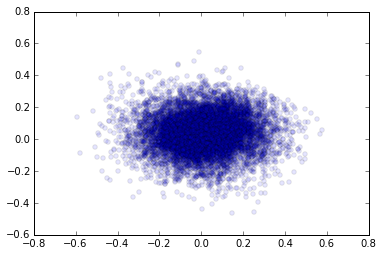

In [10]:
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(z_vals[:, 0], z_vals[:, 1], alpha=0.1)
plt.show()

This corresponds to figure 3a in the paper. Our latent variables have a smaller magnitude overall, but exhibit a roughly Gaussian distribution just like in the paper.

Now let's generate some reconstructions. Our aim is to reproduce figures 3b and 3c. We'll need to compile a function that allows us to set the desired values for the latent variables `y` and `z`.

Lasagne makes it possible to map any layer in the network to a custom expression by supplying a dictionary to `nn.layers.get_output()`. We'll make use of this to 'clamp' the observed and latent representation variables.

In [11]:
y_clamped = T.ivector('y_clamped')
z_clamped = T.matrix('z_clamped')

x_recon = nn.layers.get_output(l_decoder_out, {
        l_observed: nn.utils.one_hot(y_clamped, m=10),
        l_latent: z_clamped,
    })

reconstruct = theano.function([y_clamped, z_clamped], x_recon)

In [20]:
z_max = 0.3
ys = np.repeat(np.arange(10), 9).astype('int32')
zs = np.tile(np.linspace(-z_max, z_max, 9), 10).astype(theano.config.floatX)
z1s = np.vstack([zs, np.zeros_like(zs)]).T
z2s = np.vstack([np.zeros_like(zs), zs]).T

In [21]:
reconstructions_z1 = reconstruct(ys, z1s)
reconstructions_z2 = reconstruct(ys, z2s)

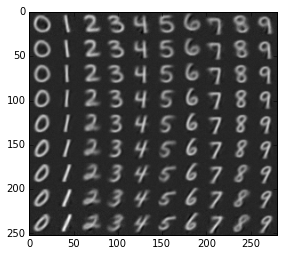

In [22]:
im1 = reconstructions_z1.reshape(10, 9, 28, 28).transpose(1, 2, 0, 3).reshape(9 * 28, 10 * 28)
plt.imshow(im1, cmap=plt.cm.gray)
plt.show()

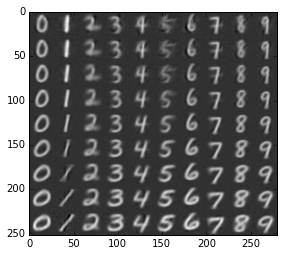

In [23]:
im2 = reconstructions_z2.reshape(10, 9, 28, 28).transpose(1, 2, 0, 3).reshape(9 * 28, 10 * 28)
plt.imshow(im2, cmap=plt.cm.gray)
plt.show()

The reconstructions show some interesting structure as `z1` and `z2` are varied. Pretty cool!